In [7]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

mpl.rcParams['font.size'] = 16

To test GNNs, we generate synthetic graph datasets where 2 classes differ by some controlled measures, like degree, centrality, etc.

## Constructing a list of undirected graphs with low/high degree

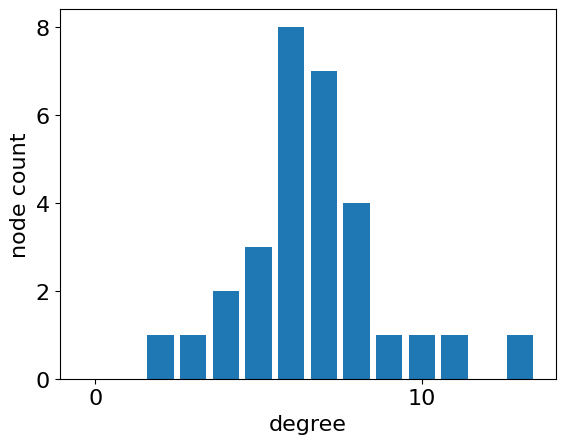

mean degree: 10.583333333333334
density: 0.22988505747126436


In [2]:
# number of nodes
n = 30
# probability of cnnection
p = 0.2

G = nx.fast_gnp_random_graph(n, p, directed=False)

hist_deg = nx.degree_histogram(G)

plt.figure()
plt.bar(range(len(hist_deg)), hist_deg)
plt.xticks(range(0,len(hist_deg),10))
plt.xlabel('degree')
plt.ylabel('node count')
plt.show()

print('mean degree:', np.mean(nx.degree(G)))
print('density:', nx.density(G))

In [3]:
# number of graph samples
n_sample = 100

# list of graphs and labels
list_G = []
labels = []

for i in range(n_sample):
    # adjust parameters depending on class
    if i<n_sample/2:
        l = 0
        p = 0.2
    else:
        l = 1
        p = 0.3
    list_G.append(nx.fast_gnp_random_graph(n, p, directed=False))
    labels.append(l)
    
labels = np.array(labels)    

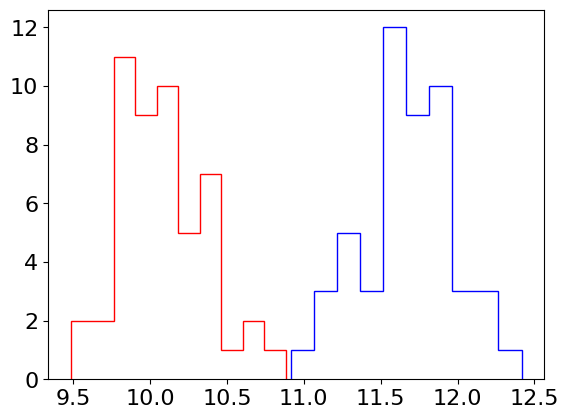

In [4]:
mean_deg = []

for G in list_G:
    mean_deg.append(np.mean(nx.degree(G)))

mean_deg = np.array(mean_deg)
    
plt.figure()
plt.hist(mean_deg[labels==0], histtype='step', color='red')
plt.hist(mean_deg[labels==1], histtype='step', color='blue')
plt.show()

## Constructing a list of undirected graphs with community structure

But similar degree and eigenvector centrality

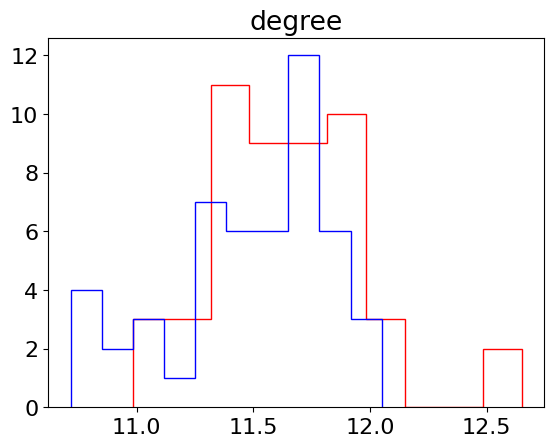

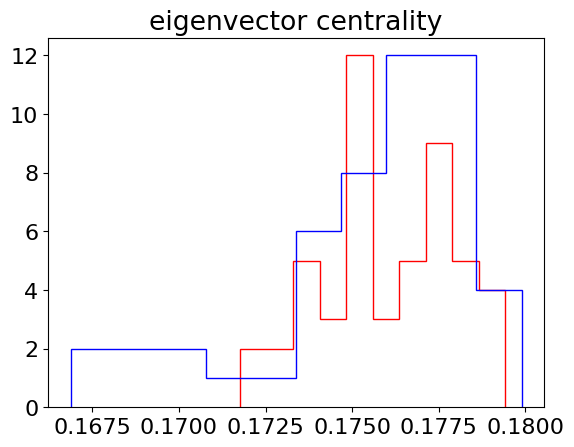

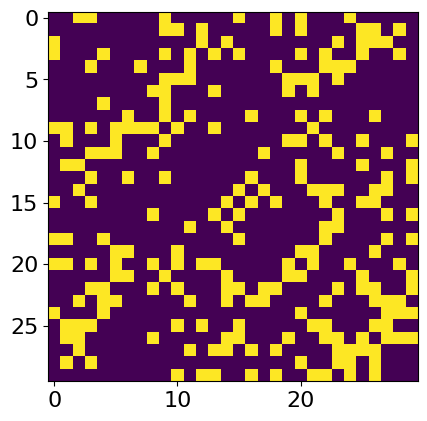

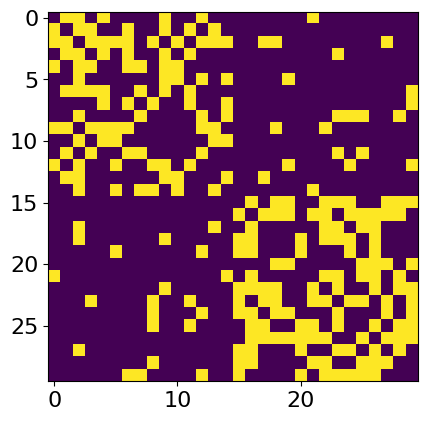

In [5]:
# number of graph samples
n_sample = 100

# list of graphs and labels
list_G = []
labels = []
mean_deg = []
mean_ec = []

for i in range(n_sample):
    if i<n_sample/2:
        l = 0
        p = 0.0
    else:
        l = 1
        p = 0.2
    sizes = [int(n/2), int(n/2)]
    G = nx.random_partition_graph(sizes, p_in=0.3+p, p_out=0.3-p)
    
    list_G.append(G)
    labels.append(l)
    
    # check eignevctor centrality
    mean_deg.append(np.mean(nx.degree(G)))
    mean_ec.append(np.mean(list(nx.eigenvector_centrality(G, max_iter=500).values())))
    
labels = np.array(labels)
mean_deg = np.array(mean_deg)
mean_ec = np.array(mean_ec)

plt.figure()
plt.title('degree')
plt.hist(mean_deg[labels==0], histtype='step', color='red')
plt.hist(mean_deg[labels==1], histtype='step', color='blue')
plt.show()

plt.figure()
plt.title('eigenvector centrality')
plt.hist(mean_ec[labels==0], histtype='step', color='red')
plt.hist(mean_ec[labels==1], histtype='step', color='blue')
plt.show()

plt.figure()
plt.imshow(nx.linalg.adjacency_matrix(list_G[0]).todense())

plt.figure()
plt.imshow(nx.linalg.adjacency_matrix(list_G[-1]).todense())

## Constructing a list of directed weighted graphs

The differences between the 2 classes can be at the global, node or connection level. It is controlled by the list of modulated nodes whose input/output connections are modulated depending on the class to which they belong.

The modulation is controled by the contrast. 

All matrices are built from a reference baseline to which noise is added, on top of the class modulation.

number of affected connections: 3


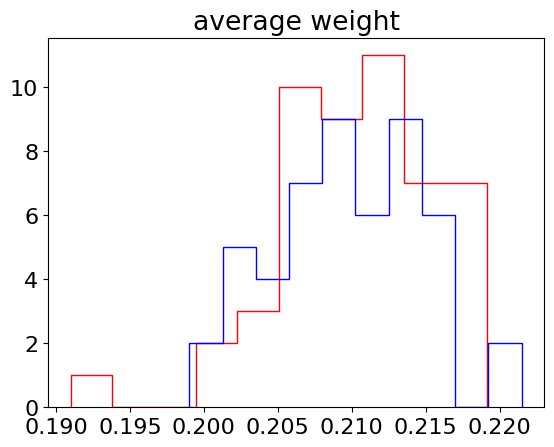

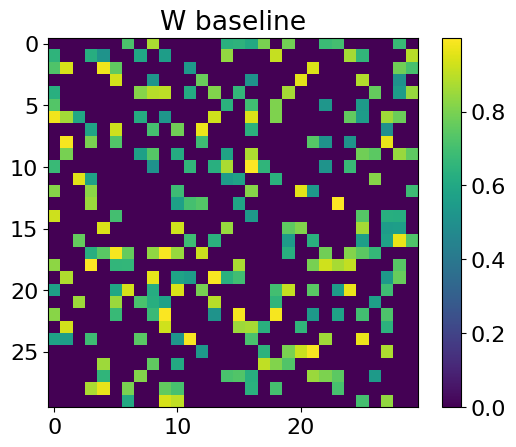

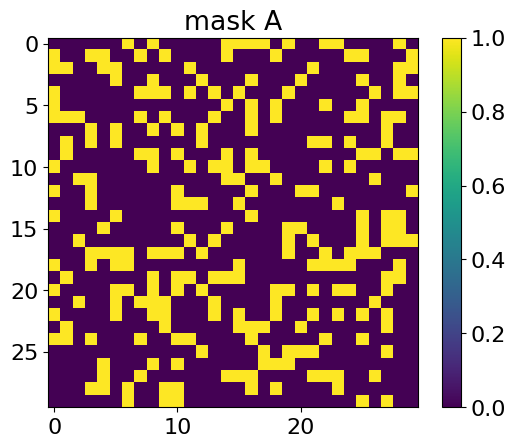

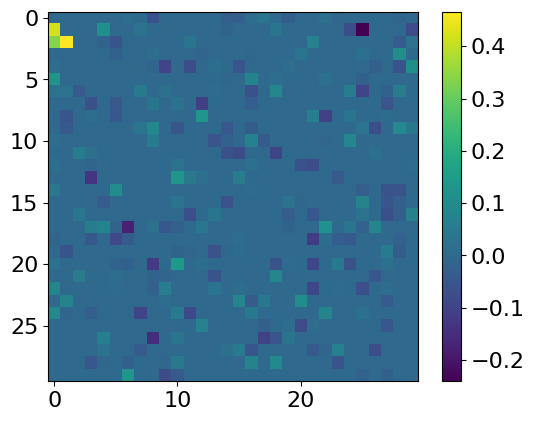

In [34]:
# number of graph samples
n_sample = 100

# class contrast
contrast = 0.2

# number of nodes
n = 30
# probability of connection (for full density, just use p=1.0)
p = 0.3
# adjacency matrix (remove self connections)
A = np.random.choice([0,1], p=[1.0-p,p], size=[n,n])
A[np.eye(n, dtype=bool)] = 0
mask_A = np.array(A, dtype=bool)
# number of edges
m = mask_A.sum()

# reference weigth matrix
W_ref = np.zeros([n,n])
W_ref[mask_A] = np.random.uniform(low=0.5, high=1.0, size=[m])

# nodes whose connections are modulated across the 2 classes
mod_nodes_in = np.arange(2)
mod_nodes_out = np.arange(4)
mask_aff = np.zeros([n,n], dtype=bool)
for i in mod_nodes_out:
    for j in mod_nodes_in:
        mask_aff[i,j] = True
mask_aff = np.logical_and(mask_aff, mask_A)
m_aff = mask_aff.sum()
print('number of affected connections:', m_aff)

# list of graphs and labels
list_G = []
list_W = np.zeros([n_sample,n,n])
labels = []
av_weight = []

for i in range(n_sample):
    if i<n_sample/2:
        l = 0
        shift = contrast
    else:
        l = 1
        shift = -contrast

    # individual noise, class marker and weight matrix
    noise = np.random.normal(scale=0.3, size=[m])
    W = np.copy(W_ref)
    W[mask_A] += noise
    W[mask_aff] += shift * (1 + np.random.normal(scale=0.3, size=[m_aff]))
        
    G = nx.from_numpy_array(W, create_using=nx.DiGraph, edge_attr='weight')
    
    list_G.append(G)
    list_W[i,:,:] = W
    labels.append(l)
    
    # check eignevctor centrality
    av_weight.append(W.mean())
    
labels = np.array(labels)
av_weight = np.array(av_weight)

plt.figure()
plt.title('average weight')
plt.hist(av_weight[labels==0], histtype='step', color='red')
plt.hist(av_weight[labels==1], histtype='step', color='blue')
plt.show()

plt.figure()
plt.title('W baseline')
plt.imshow(W_ref)
plt.colorbar()

plt.figure()
plt.title('mask A')
plt.imshow(mask_A)
plt.colorbar()

plt.figure()
contrast_W = np.mean(list_W[labels==0], axis=0) - np.mean(list_W[labels==1], axis=0)
plt.imshow(contrast_W)
plt.colorbar()


In [39]:
vect_W = list_W.reshape([n_sample,-1])

mlr = LogisticRegression(C=1.0)

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2)

acc = []
acc_shuf = []
for train_idx, test_idx in cv.split(vect_W, labels):
    # perf on data
    mlr.fit(vect_W[train_idx,:], labels[train_idx])
    acc.append(mlr.score(vect_W[test_idx,:], labels[test_idx]))
    # surrogate by shuffling
    shuf_idx = np.random.permutation(train_idx)
    mlr.fit(vect_W[train_idx,:], labels[shuf_idx])
    acc_shuf.append(mlr.score(vect_W[test_idx,:], labels[test_idx]))

print('mean(std) of acc:{} ({})'.format(np.mean(acc), np.std(acc)))
print('shuf acc:{} ({})'.format(np.mean(acc_shuf), np.std(acc_shuf)))

mean(std) of acc:0.6950000000000001 (0.08499999999999999)
shuf acc:0.495 (0.11056672193747989)
